# Task 1.1 – ECG-dataset exploration
Read training-data (ECG-time series) from a .zip-file with a .bin-file inside

In [19]:
!pwd

/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration


In [20]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install tqdm
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [17]:
import struct
import zipfile
from typing import List
import pandas as pd

# reads a binary file containing a ragged array of shorts
def read_zip_binary(path: str) -> List[List[int]]:
    ragged_array = []
    with zipfile.ZipFile(path, 'r') as zf:
        inner_path = path.split("/")[-1].split(".")[0]
        with zf.open(f'{inner_path}.bin', 'r') as r:
            read_binary_from(ragged_array, r)
    return ragged_array

def read_binary_from(ragged_array, r):
    while True:
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack('i', size_bytes)[0]
        sub_array = list(struct.unpack(f'{sub_array_size}h', r.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

# list of labels
labels = pd.read_csv("../data/y_train.csv", header=None)[0].tolist()
# list of time series
train_data = read_zip_binary("../data/X_train.zip")

# Schritt 2: Erfolg prüfen
if isinstance(train_data, list) and len(train_data) > 0 and isinstance(train_data[0], list):
    print(f"Erfolgreich geladen: {len(train_data)} Zeitreihen")
    print(f"→ Erste Zeitreihe: {len(train_data[0])} Werte, Beispiel: {train_data[0][:10]}")
else:
    print("Fehler beim Einlesen der Binärdatei.")

Erfolgreich geladen: 6179 Zeitreihen
→ Erste Zeitreihe: 9000 Werte, Beispiel: [-217, -246, -294, -344, -363, -371, -377, -379, -373, -361]


Data Exploration

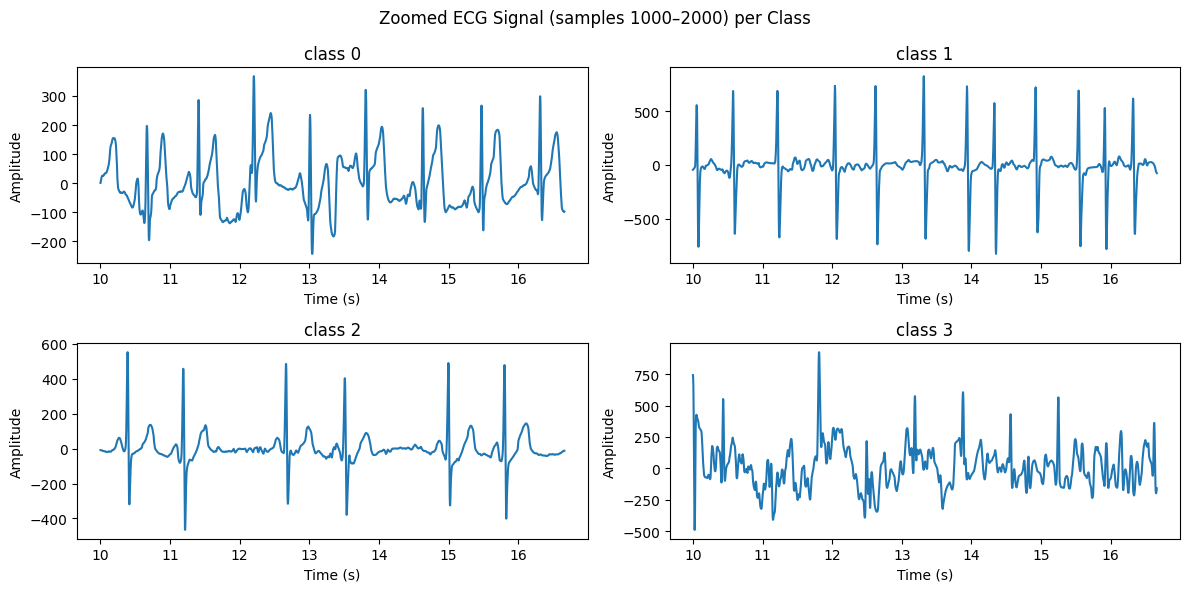

Class distribution: Counter({0: 3638, 2: 1765, 1: 549, 3: 227})


In [18]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def analyze_ecg_data(ecg_data: List[List[int]], labels: List[int]):
    lengths = [len(x) for x in ecg_data]
    df_stats = pd.DataFrame({
        "length": lengths,
        "label": labels
    })
    stats_summary = df_stats.groupby("label")["length"].describe()

    sampling_rate = 300  # Hz
    start_sample = 3000
    end_sample = 5000

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle("Zoomed ECG Signal (samples 1000–2000) per Class")
    for i in range(4):
        idx = df_stats[df_stats["label"] == i].index[0]
        example = ecg_data[idx]
        time_axis = np.arange(start_sample, end_sample) / sampling_rate
        axs[i // 2][i % 2].plot(time_axis, example[start_sample:end_sample])
        axs[i // 2][i % 2].set_title(f"class {i}")
        axs[i // 2][i % 2].set_xlabel("Time (s)")
        axs[i // 2][i % 2].set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    return stats_summary

# visualize the data
summary = analyze_ecg_data(train_data, labels)

# class distribution
class_distribution = Counter(labels)
print("Class distribution:", class_distribution)


In [22]:
from src.inference import run_inference

run_inference(
    model_path="../models/pipeline_models/best_lr0.001_wd0.0001_adam_ep100_after_meeting.pth",
    test_zip_path="../data/X_test.zip",
    output_path="../data/base.csv",
    batch_size=32
)

Load testdata..
Length of padded sequences: {18286}
Load model...
Start inference...
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])


/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration/src/inference.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1, 129, 143])
X_stft shape: torch.Size([32, 1,

In [37]:
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

# 2. DataLoader bauen
train_loader, val_loader = create_spectrogram_dataloaders(X_train_stft, y_train_split, X_val_stft, y_val_split)

# 3. Modell bauen und trainieren
model = ECGCNN()

lr = 0.001
weight_decay = 0.0001
optimizer_type = "adam"
epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = torch.tensor([3638, 549, 1765, 227], dtype=torch.float)
class_weights = 1. / class_counts
weights_tensor = class_weights.to(device)

# 4. Training und Mini-Evaluation

train_and_eval(
    model,
    train_loader,
    val_loader,
    lr=lr,
    weight_decay=weight_decay,
    optimizer_type=optimizer_type,
    epochs=epochs,
    weights_tensor=weights_tensor,
    device=device,
    save_path= f"models/pipeline_models/best_lr{lr}_wd{weight_decay}_{optimizer_type}_ep{epochs}_after_meeting.pth"
)

# 4. Validierung
run_validation(
        model_dir=f"models/pipeline_models",
        val_data_path="data/val_data.pt",
    )

Epoch: 1 Modell gespeichert: models/pipeline_models/best_lr0.001_wd0.0001_adam_ep6_after_meeting.pth (Val-Acc: 0.1102)
Epoch: 2 Modell gespeichert: models/pipeline_models/best_lr0.001_wd0.0001_adam_ep6_after_meeting.pth (Val-Acc: 0.5219)
Epoch: 3 Modell gespeichert: models/pipeline_models/best_lr0.001_wd0.0001_adam_ep6_after_meeting.pth (Val-Acc: 0.5446)
Epoch: 5 Modell gespeichert: models/pipeline_models/best_lr0.001_wd0.0001_adam_ep6_after_meeting.pth (Val-Acc: 0.5673)


/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration/src/validation.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FileNotFoundError: [Errno 2] No such file or directory: 'data/val_data.pt'

In [4]:
!pip3 install scipy

Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations, ensure_length
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

original_length = X_train_split[0].shape[0]
X_train_augmented = [
    ensure_length(apply_augmentations(x, augmentations), original_length)
    for x in X_train_split
]
X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ImportError: cannot import name 'ensure_length' from 'src.augmentation' (/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration/src/augmentation.py)

In [8]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

X_train_augmented = [apply_augmentations(x, augmentations) for x in X_train_split]

X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4945,) + inhomogeneous part.

In [ ]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

X_train_augmented = [apply_augmentations(x, augmentations) for x in X_train_split]

X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4945,) + inhomogeneous part.

In [ ]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

X_train_augmented = [apply_augmentations(x, augmentations) for x in X_train_split]

X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4945,) + inhomogeneous part.

In [10]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

X_train_augmented = [apply_augmentations(x, augmentations) for x in X_train_split]

X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

KeyboardInterrupt: 

In [16]:
from src.augmentation import (
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations, ensure_length
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders
from src.model import ECGCNN
from src.train import train_and_eval
from src.validation import run_validation
import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

original_length = X_train_split[0].shape[0]
X_train_augmented = [
    (apply_augmentations(x, augmentations), original_length)
    for x in X_train_split
]
X_train_combined = np.concatenate([X_train_split, X_train_augmented])
y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ImportError: cannot import name 'ensure_length' from 'src.augmentation' (/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration/src/augmentation.py)

In [18]:
from src.augmentation import ( ensure_length,
    time_stretch, time_shift, add_noise, random_crop,
    resample_signal, amplitude_scale, apply_augmentations
)
from src.data import load_split_data, pad_sequences, apply_stft_numpy
from src.dataset import create_spectrogram_dataloaders

import torch

# 1. Daten laden und vorverarbeiten
X_train_split, X_val_split, y_train_split, y_val_split = load_split_data("data/split_data.pkl")
X_train_split = pad_sequences(X_train_split)
X_val_split = pad_sequences(X_val_split)
X_train_stft = apply_stft_numpy(X_train_split)
X_val_stft = apply_stft_numpy(X_val_split)

import numpy as np

augmentations = [
    lambda x: time_stretch(x, rate=np.random.uniform(0.9, 1.1)),
    lambda x: time_shift(x, shift_max=0.1),
    lambda x: add_noise(x, noise_level=0.02),
    lambda x: amplitude_scale(x, scale_range=(0.8, 1.2)),
    #lambda x: frequency_domain_augment(x, noise_level=0.01)
]

original_length = X_train_split[0].shape[0]
X_train_augmented = [
    ensure_length(apply_augmentations(x, augmentations), original_length)
    for x in X_train_split
]

try:
    X_train_combined = np.stack([*X_train_split, *X_train_augmented])
except ValueError as e:
    print("Shape mismatch! Printing shapes for debugging:")
    print("Original:", [x.shape for x in X_train_split])
    print("Augmented:", [x.shape for x in X_train_augmented])
    raise e

y_train_combined = np.concatenate([y_train_split, y_train_split])

X_train_stft = apply_stft_numpy(X_train_combined)
train_loader, val_loader = create_spectrogram_dataloaders(
    X_train_stft, y_train_combined, X_val_stft, y_val_split
)

ImportError: cannot import name 'ensure_length' from 'src.augmentation' (/Users/andrearachetta/Documents/GitHub/AMLS_Exercise/1.1_dataset_exploration/src/augmentation.py)

In [30]:
!pip install scikit-learn

validation split (80% for training / 20 % for validation)

In [32]:
from collections import Counter
import pickle
import random

def stratified_train_test_split(data, labels, test_size=0.2, random_state=42):
    """
    Manually performs stratified train-test split without sklearn
    
    Args:
        data: List of data samples
        labels: List of corresponding labels
        test_size: Proportion of data to use for validation (default: 0.2)
        random_state: Random seed for reproducibility
    
    Returns:
        X_train, X_val, y_train, y_val
    """
    if random_state is not None:
        random.seed(random_state)
    
    # Group data by class
    class_data = {}
    for i, label in enumerate(labels):
        if label not in class_data:
            class_data[label] = []
        class_data[label].append(i)
    
    train_indices = []
    val_indices = []
    
    # For each class, split proportionally
    for label, indices in class_data.items():
        # Shuffle indices for this class
        shuffled_indices = indices.copy()
        random.shuffle(shuffled_indices)
        
        # Calculate split point
        n_val = int(len(shuffled_indices) * test_size)
        if n_val == 0 and len(shuffled_indices) > 0:
            n_val = 1  # Ensure at least one sample in validation if class exists
        
        # Split indices
        val_indices.extend(shuffled_indices[:n_val])
        train_indices.extend(shuffled_indices[n_val:])
    
    # Create final splits
    X_train = [data[i] for i in train_indices]
    X_val = [data[i] for i in val_indices]
    y_train = [labels[i] for i in train_indices]
    y_val = [labels[i] for i in val_indices]
    
    return X_train, X_val, y_train, y_val

# Your original code adapted to use the manual function
# Input:
# train_data: Liste von ECG-Zeitreihen
# labels: Liste der zugehörigen Klassen (gleiche Länge)

X_train_split, X_val_split, y_train_split, y_val_split = stratified_train_test_split(
    train_data,
    labels,
    test_size=0.2,  # 20% for validation
    random_state=42  # for reproducibility
)

# Output:
# X_train_split: Trainingsdaten
# X_val_split: Validierungsdaten
# y_train_split: Labels für Trainingsdaten
# y_val_split: Labels für Validierungsdaten

# Speichern der Listen
with open("../data/split_data.pkl", "wb") as f:
    pickle.dump((X_train_split, X_val_split, y_train_split, y_val_split), f)

print(f"Trainingsdaten: {len(X_train_split)} Zeitreihen")
print(f"Validierungsmenge: {len(X_val_split)} Beispiele")

# class distribution
print("Train-class-distribution:", Counter(y_train_split))
print("Val-class-distribution:", Counter(y_val_split))

Trainingsdaten: 4945 Zeitreihen
Validierungsmenge: 1234 Beispiele
Train-class-distribution: Counter({0: 2911, 2: 1412, 1: 440, 3: 182})
Val-class-distribution: Counter({0: 727, 2: 353, 1: 109, 3: 45})
